In [ ]:
import os
print(os.getcwd())
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.linear_model import LogisticRegression
from FeatBoost.feat_selector import FeatureSelector
import json
import gc
from sklearn.model_selection import StratifiedKFold, ParameterGrid
import json
import csv
import uncertainty
from scipy.stats import beta


In [ ]:
import os
print(os.getcwd())


In [ ]:
gim_cohort = pd.read_parquet("./DataProcessing/Sep_24_gim_icd10.parquet")
sbk_gim = pd.read_parquet("./DataProcessing/Sep_24_sbk_gim_icd10.parquet")

non_gim_cohort = pd.read_parquet("./DataProcessing/Sep_24_non_gim_icd10.parquet")
locality = pd.read_csv("./fair_interpretable/fair_inter_locality_v2_update.csv")
statcan = pd.read_csv('./fair_interpretable/statcan_table.csv')
zero_sum_columns = [col for col in gim_cohort.columns if gim_cohort[col].sum() == 0]
gim_cohort = gim_cohort.drop(columns=zero_sum_columns)
sbk_gim = sbk_gim.drop(columns=zero_sum_columns)
non_gim_cohort = non_gim_cohort.drop(columns=zero_sum_columns)


In [ ]:
fairness = locality.merge(statcan, how = 'left', on = 'da21uid')
print(fairness.shape)
fairness = fairness[['genc_id', 'households_dwellings_q_DA21','material_resources_q_DA21','age_labourforce_q_DA21','racialized_NC_pop_q_DA21']]
fairness.columns = ['genc_id', 'households_dwellings', 'material_resources', 'age_labourforce', 'racialized']
del locality
del statcan
gc.collect()
fairness_columns = list(fairness.columns)[1:]
print(fairness_columns)

In [ ]:
gim_cohort = gim_cohort.drop_duplicates()
gim_cohort = gim_cohort.reset_index(drop=True)
gim_cohort = pd.concat([gim_cohort, sbk_gim], ignore_index=True)

In [ ]:
gim_cohort.shape

In [ ]:
def prevalence_rate(y, fairness_features_df, culmulative=False):
    """
    Calculate prevalence rate of delirium across fairness feature groups
    """
    prevalence_rates = []
    for fairness_feature in fairness_features_df.columns:
        if culmulative:
            if fairness_feature == "gender_F":
                splits = [0]
            else:
                splits = [1,2,3,4]
            for split in splits:
                fairness_binary = (fairness_features_df[fairness_feature]>split).astype(int)
                group0_mask = fairness_binary == 0
                group1_mask = fairness_binary == 1
               
    

In [ ]:
def predict_normal(model, X_test):
    preds = model.predict(X_test)
    pred_probs = model.predict_proba(X_test)[:, 1]
    pred_probs_all = model.predict_proba(X_test)
    return preds, pred_probs, pred_probs_all

def calc_metrics(prediction, prediction_prob, labels, k=10):
    acc = accuracy_score(labels, prediction)
    f1 = f1_score(labels, prediction, average='binary')  # Use 'micro', 'macro', 'weighted' for multi-class
    precision = precision_score(labels, prediction, average='binary')
    recall = recall_score(labels, prediction, average='binary')
    roc_auc = roc_auc_score(labels, prediction_prob)
    
    # Precision@k calculation
    # Sort by prediction probabilities in descending order
    sorted_indices = np.argsort(prediction_prob)[::-1]
    top_k_indices = sorted_indices[:k]
    
    # Count true positives in the top k predictions
    top_k_labels = np.array(labels)[top_k_indices]
    precision_at_k = np.sum(top_k_labels) / k
    
    return acc, f1, precision, recall, roc_auc, precision_at_k
    # return acc, f1, precision, recall, roc_auc


def expected_calibration_error(samples, true_labels, M=10):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = np.max(samples, axis=1)
    # get predictions from confidences (positional in this case)
    predicted_label = np.argmax(samples, axis=1)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece[0]

def ace(samples, true_labels, bin_size=25):
    """
    Calculate the Adaptive Calibration Error (ACE) for a set of predictions.
    
    Args:
    samples (np.ndarray): Array of predicted probabilities for each class (shape: [num_samples, num_classes]).
    true_labels (np.ndarray): Array of true class labels.
    bin_size (int): Number of points in each bin.

    Returns:
    float: The calculated Adaptive Calibration Error (ACE).
    """
    num_samples = samples.shape[0]
    assert num_samples == len(true_labels), "Number of samples and true labels must match."

    # Get max probability per sample
    confidences = np.max(samples, axis=1)
    # confidences = samples[:, 1]

    # Get predictions from confidences
    predicted_label = np.argmax(samples, axis=1)

    # Get a boolean list of correct/false predictions
    accuracies = predicted_label == true_labels

    # Sort by confidence
    sorted_indices = np.argsort(confidences)
    sorted_confidences = confidences[sorted_indices]
    sorted_accuracies = accuracies[sorted_indices]

    ace = 0.0
    start_idx = 0
    
    mean_conf = []
    mean_acc = []
    while start_idx < num_samples:
        end_idx = min(start_idx + bin_size, num_samples)
        
        bin_confidences = sorted_confidences[start_idx:end_idx]
        bin_accuracies = sorted_accuracies[start_idx:end_idx]

        # Mean predicted probability in the bin
        mean_confidence = np.mean(bin_confidences)
        # Mean accuracy in the bin
        mean_accuracy = np.mean(bin_accuracies)
        
        mean_conf.append(mean_confidence)
        mean_acc.append(mean_accuracy)

        # Calculate bin contribution to ACE
        ace += np.abs(mean_confidence - mean_accuracy) * len(bin_confidences) / num_samples

        start_idx = end_idx

    return ace, mean_conf, mean_acc

# def calc_metrics_at_thresholds(num_features, prediction_prob, labels, thresholds=[0.5], k=10):
#     results = []
    
#     # Calculate the ROC AUC once, as it does not depend on the threshold
#     roc_auc = roc_auc_score(labels, prediction_prob)
    
#     # Calculate Precision@k
#     # Sort by prediction probabilities in descending order and take the top k predictions
#     sorted_indices = np.argsort(prediction_prob)[::-1]
#     top_k_indices = sorted_indices[:k]
#     top_k_labels = np.array(labels)[top_k_indices]
#     precision_at_k = np.sum(top_k_labels) / k

#     for threshold in thresholds:
#         # Apply the threshold to generate predictions
#         prediction = (prediction_prob >= threshold).astype(int)
        
#         # Calculate metrics
#         acc = accuracy_score(labels, prediction)
#         f1 = f1_score(labels, prediction, average='binary')
#         precision = precision_score(labels, prediction, average='binary')
#         recall = recall_score(labels, prediction, average='binary')
#         map_k = apk_binary(labels, prediction_prob, k=labels.shape[0])
        
#         # Calculate the percentage of positive predictions
#         pred_positive_percentage = np.mean(prediction) 
#         true_positive_percentage = np.mean(labels)
        
#         # Append the results as a row to the list
#         results.append({
#             'num_features': num_features,
#             'threshold': threshold,
#             'accuracy': acc,
#             'f1_score': f1,
#             'precision': precision,
#             'recall': recall,
#             'roc_auc': roc_auc,
#             'precision_at_k': precision_at_k,
#             'map@k': map_k,
#             'pred_positive_percentage': pred_positive_percentage,
#             'true_positive_percentage': true_positive_percentage
#         })
    
#     return results


# helper function of calc_metrics_at_thresholds
def compute_group_metrics(y_true, y_pred):
    """Compute TPR, FPR, Precision, and Recall for a given group."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    FPR = FP / (FP + TN) if (FP + TN) > 0 else np.nan
    precision = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    recall = TPR  # Recall is the same as TPR
    
    return TPR, FPR, precision, recall

# def calc_metrics_at_thresholds(num_features, prediction_prob, labels, fairness_features_df, thresholds=[0.5], k=10, cumulative=False):
#     """ 
#     Compute the fairness score at different thresholds at different split, and different fairness features
#     """
    
#     results = []
    
#     # Calculate the ROC AUC once, as it does not depend on the threshold
#     roc_auc = roc_auc_score(labels, prediction_prob)
    
#     # Calculate Precision@k
#     # Sort by prediction probabilities in descending order and take the top k predictions
#     sorted_indices = np.argsort(prediction_prob)[::-1]
#     top_k_indices = sorted_indices[:k]
#     top_k_labels = np.array(labels)[top_k_indices]
#     precision_at_k = np.sum(top_k_labels) / k

#     for threshold in thresholds:
#         # Apply the threshold to generate predictions
#         prediction = (prediction_prob >= threshold).astype(int)
        
#         # Calculate metrics
#         correct_prediction = labels == prediction
#         acc = np.mean(correct_prediction)
#         f1 = f1_score(labels, prediction, average='binary')
#         precision = precision_score(labels, prediction, average='binary')
#         recall = recall_score(labels, prediction, average='binary')
#         map_k = apk_binary(labels, prediction_prob, k=labels.shape[0])
        
#         # Calculate the percentage of positive predictions
#         pred_positive_percentage = np.mean(prediction) 
#         true_positive_percentage = np.mean(labels)
        
#         for fairness_feature in list(fairness_features_df.columns):
#             if fairness_feature == "gender_F":
#                 splits = [0]
#             else:
#                 splits = [1,2,3,4]
#             for split in splits:

#                 # Split the data into privileged and unprivileged groups based on the fairness feature
    
#                 fairness_binary = (fairness_features_df[fairness_feature]>split).astype(int)
#                 group0_mask = fairness_binary == 0
#                 group1_mask = fairness_binary == 1
               
#                 if sum(group0_mask) == 0 or sum(group1_mask) == 0:
#                     continue
                    
#                 group0_labels = np.array(labels)[group0_mask]
#                 group0_preds = np.array(prediction)[group0_mask]
    
#                 group1_labels = np.array(labels)[group1_mask]
#                 group1_preds = np.array(prediction)[group1_mask]

#                 TPR_0, FPR_0, precision_0, recall_0 = compute_group_metrics(group0_labels, group0_preds)
#                 TPR_1, FPR_1, precision_1, recall_1 = compute_group_metrics(group1_labels, group1_preds)

#                 tpr_diff = TPR_1 - TPR_0
#                 fpr_diff = FPR_1 - FPR_0
#                 prec_diff = precision_1 - precision_0
#                 rec_diff = recall_1 - recall_0

#                 ##### Bayesian Unfairness and Uncertainty
#                 # Setting correct prediction as the favorable outcome, Bayesian disparity assumes both groups have a 50% chance of receiving the favorable outcome.
#                 E1 = correct_prediction 
#                 E2 = True
#                 bayesian_disparity = uncertainty.bayesian_disparity(group0_mask, group1_mask, E1, E2)
#                 bayesian_disparity_abs = np.abs(bayesian_disparity)
#                 uncertainty_value = uncertainty.uncertainty(group0_mask, group1_mask, E1, E2)

                
    
#                 results.append({
#                         'split_point': split,
#                         'num_features': num_features,
#                         'threshold': threshold,
#                         'fairness_feature': fairness_feature,
#                         'group_0_size': int((fairness_binary == 0).sum()),
#                         'group_1_size': int((fairness_binary == 1).sum()),
#                         'accuracy': acc,
#                         'f1_score': f1,
#                         'precision': precision,                        
#                         'recall': recall,
#                         'roc_auc': roc_auc,
#                         'precision_at_k': precision_at_k,
#                         'map@k': map_k,
#                         'pred_positive_percentage': pred_positive_percentage,
#                         'true_positive_percentage': true_positive_percentage,
#                         'tpr_diff_abs': abs(tpr_diff),
#                         'fpr_diff_abs': abs(fpr_diff),
#                         'tpr_diff_raw': tpr_diff,
#                         'fpr_diff_raw': fpr_diff,
#                         'precision_diff_abs': abs(prec_diff),
#                         'recall_diff_abs': abs(rec_diff),
#                         'equalized_odds_max': max(abs(tpr_diff), abs(fpr_diff)),
#                         'equalized_odds': 0.5*(abs(tpr_diff) + abs(fpr_diff)),
#                         'bayesian_disparity': bayesian_disparity,
#                         'bayesian_disparity_abs':bayesian_disparity_abs,
#                         'bayesian_uncertainty': uncertainty_value
#                         })
#                 df = pd.DataFrame(results)
#                 # max_eod_df = df.loc[df.groupby('fairness_feature')['equalized_odds'].idxmax()]
 
            
#     return df #max_eod_df
def calc_metrics_at_thresholds(num_features, prediction_prob, labels, fairness_features_df, thresholds=[0.5], k=10, cumulative=False):
    """ 
    Compute the fairness score at different thresholds at different split, and different fairness features
    """
    
    results = []
    
    # Calculate the ROC AUC once, as it does not depend on the threshold
    roc_auc = roc_auc_score(labels, prediction_prob)
    
    # Calculate Precision@k
    # Sort by prediction probabilities in descending order and take the top k predictions
    sorted_indices = np.argsort(prediction_prob)[::-1]
    top_k_indices = sorted_indices[:k]
    # Create a mask for the top k predictions
    top_k_mask = np.zeros(len(labels), dtype=bool)
    top_k_mask[top_k_indices] = True

    top_k_labels = np.array(labels)[top_k_indices]
    precision_at_k = np.sum(top_k_labels) / k

    for threshold in thresholds:
        # Apply the threshold to generate predictions
        prediction = (prediction_prob >= threshold).astype(int)
        
        # Calculate metrics
        correct_prediction = labels == prediction
        acc = np.mean(correct_prediction)
        f1 = f1_score(labels, prediction, average='binary')
        precision = precision_score(labels, prediction, average='binary')
        recall = recall_score(labels, prediction, average='binary')
        map_k = apk_binary(labels, prediction_prob, k=labels.shape[0])
        
        # Calculate the percentage of positive predictions
        pred_positive_percentage = np.mean(prediction) 
        true_positive_percentage = np.mean(labels)
        
        for fairness_feature in list(fairness_features_df.columns):
            if cumulative:
                ## Cumulative split points for fairness features
                if fairness_feature == "gender_F":
                    splits = [0]
                else:
                    splits = [1,2,3,4]
                col_name_split = "cumulative_split_point(<= split)"
                
            else:
                # exact split points for fairness features
                splits = sorted(fairness_features_df[fairness_feature].unique())
                col_name_split = "exact_split_point(== split)"
            for split in splits:

                if cumulative:
                    # Convert the fairness feature to binary based cumulative split points ex. (<= split) -> 1 , (> split) -> 0
                    fairness_binary = (fairness_features_df[fairness_feature]<=split).astype(int)
                else:
                    # Convert the fairness feature to binary based exat split points ex.(== split) -> 1, (!= split) -> 0
                    fairness_binary = (fairness_features_df[fairness_feature] == split).astype(int)
                group0_mask = fairness_binary == 0
                group1_mask = fairness_binary == 1

                ### prevalence rate
                ##“How common is label = 1 in this group in the real world?”	Large natural imbalance → model must handle different base-rates.
                prevalence_rate1 = (labels[group1_mask].sum() / len(labels[group1_mask])) if len(labels[group1_mask]) > 0 else 0
                prevalence_rate0 = (labels[group0_mask].sum() / len(labels[group0_mask])) if len(labels[group0_mask]) > 0 else 0


                # calculate prevalence rate of delirium across fairness feature groups @ the top k predictions
                #“Among the group’s members who made the shortlist (top-k), what fraction truly need/deserve the action?” (precision of ranking within the group)	
                # One group’s Prev@k ≫ another’s → scarce slots for the second group are ‘wasted’ on false positives or its true positives are being outranked.
                prevalence_rate1_k = (labels[group1_mask&top_k_mask].sum() / len(labels[group1_mask&top_k_mask])) if len(labels[group1_mask&top_k_mask]) > 0 else 0
                prevalence_rate0_k = (labels[group0_mask&top_k_mask].sum() / len(labels[group0_mask&top_k_mask])) if len(labels[group0_mask&top_k_mask]) > 0 else 0

                ### treatment rate
                # “With my chosen threshold, how often do I give the positive decision to this group?”	
                # #Gap ≫ prevalence gap → model amplifies imbalance; gap ≪ prevalence gap → model may under-serve high-need group.
                treatment_rate1 = (prediction[group1_mask].sum() / len(prediction[group1_mask])) if len(prediction[group1_mask]) > 0 else 0
                treatment_rate0 = (prediction[group0_mask].sum() / len(prediction[group0_mask])) if len(prediction[group0_mask]) > 0 else 0

                # calculate treatment rate of delirium across fairness feature groups @ the top k predictions
                # “What share of the entire group lands in the topk?” (allocation of a limited resource)	
                # TR@k gap shows direct disparate opportunity or burden when capacity is capped 
                treatment_rate1_k = (group1_mask & top_k_mask).sum() / group1_mask.sum() if group1_mask.sum() > 0 else 0
                treatment_rate0_k = (group0_mask & top_k_mask).sum() / group0_mask.sum() if group0_mask.sum() > 0 else 0



            
                if sum(group0_mask) == 0 or sum(group1_mask) == 0:
                    continue
                    
                group0_labels = np.array(labels)[group0_mask]
                group0_preds = np.array(prediction)[group0_mask]
    
                group1_labels = np.array(labels)[group1_mask]
                group1_preds = np.array(prediction)[group1_mask]

                TPR_0, FPR_0, precision_0, recall_0 = compute_group_metrics(group0_labels, group0_preds)
                TPR_1, FPR_1, precision_1, recall_1 = compute_group_metrics(group1_labels, group1_preds)

                tpr_diff = TPR_1 - TPR_0
                fpr_diff = FPR_1 - FPR_0
                prec_diff = precision_1 - precision_0
                rec_diff = recall_1 - recall_0

                # Calculate the tpr, fpr, precision, recall  @k
                TPR_0_k, FPR_0_k, precision_0_k, recall_0_k = compute_group_metrics(labels[group0_mask], # y_true  (only group-0 rows)
                                                                                    top_k_mask[group0_mask]) # y_pred  (1 if that row is in the top-k)
                TPR_1_k, FPR_1_k, precision_1_k, recall_1_k = compute_group_metrics(labels[group1_mask], 
                                                                                    top_k_mask[group1_mask])
                tpr_diff_k = TPR_1_k - TPR_0_k
                fpr_diff_k = FPR_1_k - FPR_0_k
                prec_diff_k = precision_1_k - precision_0_k
                rec_diff_k = recall_1_k - recall_0_k



                ##### Bayesian Unfairness and Uncertainty
                # Setting correct prediction as the favorable outcome, Bayesian disparity assumes both groups have a 50% chance of receiving the favorable outcome.
                E1 = correct_prediction 
                E2 = True
                bayesian_disparity = uncertainty.bayesian_disparity(group0_mask, group1_mask, E1, E2)
                bayesian_disparity_abs = np.abs(bayesian_disparity)
                uncertainty_value = uncertainty.uncertainty(group0_mask, group1_mask, E1, E2)


                # Calculate the uncertainty value@k
                E1_k = labels&top_k_mask&prediction
                E2_k = True
                bayesian_disparity_k = uncertainty.bayesian_disparity(group1_mask, group0_mask, E1_k, E2_k)
                bayesian_disparity_abs_k = np.abs(bayesian_disparity_k)
                uncertainty_value_k = uncertainty.uncertainty(group0_mask, group1_mask, E1_k, E2_k)

                
    
                results.append({
                        'num_features': num_features,
                        'threshold': threshold,
                        'fairness_feature': fairness_feature,
                        col_name_split: split,
                        'k': k,
                        'group_0_size': int((fairness_binary == 0).sum()),
                        'group_1_size': int((fairness_binary == 1).sum()),
                        'accuracy': acc,
                        'f1_score': f1,
                        'precision': precision,                        
                        'recall': recall,
                        'roc_auc': roc_auc,
                        'precision_at_k': precision_at_k,
                        'map@k': map_k,
                        'pred_positive_percentage': pred_positive_percentage,
                        'true_positive_percentage': true_positive_percentage,
                        'tpr_diff_abs': abs(tpr_diff),
                        'fpr_diff_abs': abs(fpr_diff),
                        'tpr_diff_raw': tpr_diff,
                        'fpr_diff_raw': fpr_diff,
                        'precision_diff_abs': abs(prec_diff),
                        'recall_diff_abs': abs(rec_diff),
                        'equalized_odds_max': max(abs(tpr_diff), abs(fpr_diff)),
                        'equalized_odds': 0.5*(abs(tpr_diff) + abs(fpr_diff)),
                        'bayesian_disparity': bayesian_disparity,
                        'bayesian_disparity_abs':bayesian_disparity_abs,
                        'bayesian_uncertainty': uncertainty_value,
                        'prevalence_rate1': prevalence_rate1,
                        'prevalence_rate0': prevalence_rate0,
                        'treatment_rate1': treatment_rate1,
                        'treatment_rate0': treatment_rate0,
                        'prevalence_rate1@k': prevalence_rate1_k,
                        'prevalence_rate0@k': prevalence_rate0_k,
                        'treatment_rate1@k': treatment_rate1_k,
                        'treatment_rate0@k': treatment_rate0_k,
                        'tpr_0@k': TPR_0_k,
                        'fpr_0@k': FPR_0_k,
                        'precision_0@k': precision_0_k,
                        'recall_0@k': recall_0_k,
                        'tpr_1@k': TPR_1_k,
                        'fpr_1@k': FPR_1_k,
                        'precision_1@k': precision_1_k,
                        'recall_1@k': recall_1_k,
                        'tpr_diff@k': tpr_diff_k,
                        'fpr_diff@k': fpr_diff_k,
                        'precision_diff@k': prec_diff_k,
                        'recall_diff@k': rec_diff_k,
                        'bayesian_disparity@k': bayesian_disparity_k,
                        'bayesian_disparity_abs@k': bayesian_disparity_abs_k,
                        'bayesian_uncertainty@k': uncertainty_value_k,
                        'equalized_odds_max@k': max(abs(tpr_diff_k), abs(fpr_diff_k)),
                        'equalized_odds@k': 0.5*(abs(tpr_diff_k) + abs(fpr_diff_k))
                        })
    
    df = pd.DataFrame(results)
    # max_eod_df = df.loc[df.groupby('fairness_feature')['equalized_odds'].idxmax()]
            
            
                    

 
            
    return df #max_eod_df





def dist_plot_top_k(prediction_prob, fairness_feature, k=10):
    # Sort by prediction probabilities in descending order and take the top k predictions
    sorted_indices = np.argsort(prediction_prob)[::-1]
    top_k_indices = sorted_indices[:k]
    top_k_fairness_feature = np.array(fairness_feature)[top_k_indices]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the distribution of the top k predictions
    ax[0].hist(prediction_prob[top_k_indices], bins=20, color='skyblue', edgecolor='black')
    ax[0].set_title(f'Distribution of Top {k} Predictions')
    ax[0].set_xlabel('Prediction Probability')
    ax[0].set_ylabel('Count')
    
    # Plot the distribution of the fairness feature in the top k predictions
    ax[1].hist(top_k_fairness_feature, bins=20, color='lightcoral', edgecolor='black')
    ax[1].set_title(f'Distribution of Fairness Feature in Top {k} Predictions')
    ax[1].set_xlabel('Fairness Feature Value')
    ax[1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()


def _fairness_metrics_one_sample(num_features,
                                 prediction_prob,
                                 labels,
                                 fairness_features_df,
                                 **calc_kwargs):
    """
    Returns the DataFrame produced by `calc_metrics_at_thresholds`, but *only*
    the columns that contain '@k'.
    """
    df_metrics = calc_metrics_at_thresholds(
        num_features=num_features,
        prediction_prob=prediction_prob,
        labels=labels,
        fairness_features_df=fairness_features_df,
        **calc_kwargs                      # thresholds, k, cumulative…
    )
    at_k_cols = [c for c in df_metrics.columns if '@k' in c]
    key_cols  = list(df_metrics.columns[1:4])

    # Keep the keys (so we can align rows across bootstrap iterations)
    # and the @k metric columns only
    return df_metrics[key_cols + at_k_cols]


def bootstrap_ci_for_k_metrics(num_features,
                               prediction_prob,
                               labels,
                               fairness_features_df,
                               n_iterations=1_000,
                               alpha=0.05,
                               sample_proportion=1.0,
                               random_state=42,
                               **calc_kwargs):
    """
    Return a DataFrame whose rows mirror those of `calc_metrics_at_thresholds`
    and whose columns give point estimate, variance and CI bounds for every
    metric that contains '@k'.
    """
    rng = np.random.default_rng(random_state)

    # --- 1. run once on the *full* data → point estimate -------------------
    full_df = _fairness_metrics_one_sample(
        num_features, prediction_prob, labels, fairness_features_df,
        **calc_kwargs
    )

    key_cols  = [c for c in full_df.columns if '@k' not in c]
    metric_cols = [c for c in full_df.columns if '@k' in c]

    # keep point estimates for later merge
    summary = full_df[key_cols].copy()
    # for col in metric_cols:
    #     summary[f'{col}_point'] = full_df[col]

    # --- 2. bootstrap loop -------------------------------------------------
    boot_tables = []
    for _ in range(n_iterations):
        # resample row indices *with replacement*
        n_rows   = len(labels)
        n_samp   = int(n_rows * sample_proportion)
        idx_boot = rng.choice(n_rows, size=n_samp, replace=True)

        boot_pred   = prediction_prob[idx_boot]
        boot_labels = labels[idx_boot]
        boot_feat   = fairness_features_df.iloc[idx_boot].reset_index(drop=True)
        boot_df = _fairness_metrics_one_sample(
            num_features, boot_pred, boot_labels, boot_feat,
            **calc_kwargs
        )
        boot_tables.append(boot_df[metric_cols])

    # shape → (n_iter, n_rows, n_metrics)
    boot_stack = np.stack([t.values for t in boot_tables])

    # --- 3. variance and CI per row / per metric ---------------------------
    means = boot_stack.mean(axis=0)
    var_vals = boot_stack.var(axis=0, ddof=1)
    lower_q  = np.quantile(boot_stack, alpha / 2, axis=0)
    upper_q  = np.quantile(boot_stack, 1 - alpha / 2, axis=0)

    # attach to summary DataFrame
    for j, col in enumerate(metric_cols):
        summary[f'{col}_mean'] = means[:, j]
        summary[f'{col}_var']  = var_vals[:, j]
        summary[f'{col}_ci']   = list(zip(lower_q[:, j], upper_q[:, j]))
    return summary, boot_tables, metric_cols



In [ ]:

def plot_bootstrap_dists(
    summary,
    boot_tables,
    metric_cols,
    row_idx,
    bins=30
):
    """
    Plot bootstrap histograms *per metric* for **one specific row** (setting).

    Parameters
    ----------
    boot_tables : list[pd.DataFrame]
        One DataFrame per bootstrap iteration, rows = settings, cols = metrics.
    metric_cols : list[str]
        Metrics you want to inspect (e.g. the '@k' columns).
    row_idx : int
        Index of the row / setting to inspect (same row order as in boot_tables).
    bins : int, default 30
        Histogram bin count.
    """
    for metric in metric_cols:
        # collect the metric’s value for this row across all iterations
        samples = np.array([tbl.iloc[row_idx][metric] for tbl in boot_tables])
        title = f"feature-{summary.iloc[row_idx,1:3].iloc[0]}, split-{summary.iloc[row_idx,1:3].iloc[1]}"
        plt.figure(figsize=(4, 3))
        plt.hist(samples, bins=bins, color='skyblue', edgecolor='black')
        plt.axvline(samples.mean(), color='red', ls='--', lw=1, label='mean')
        plt.title(title)
        plt.xlabel('value')
        plt.ylabel('count')
        plt.legend()
        plt.tight_layout()
        plt.show()



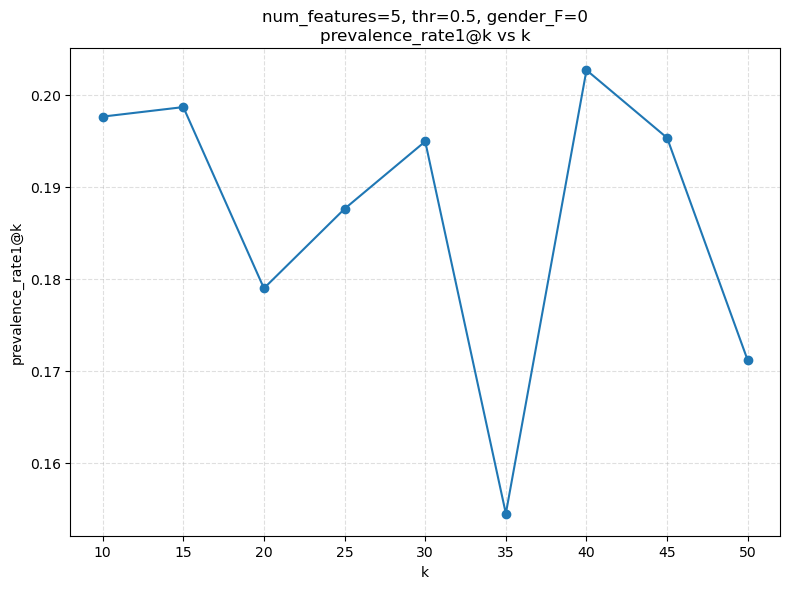

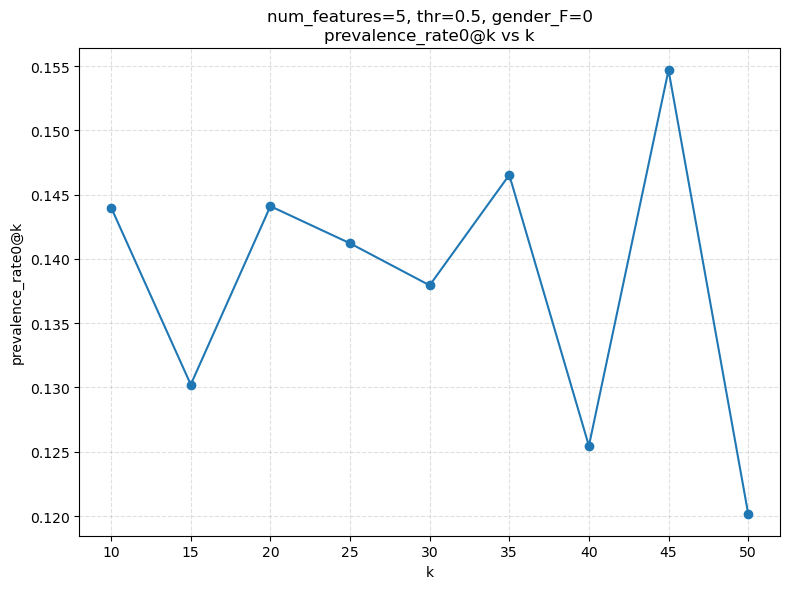

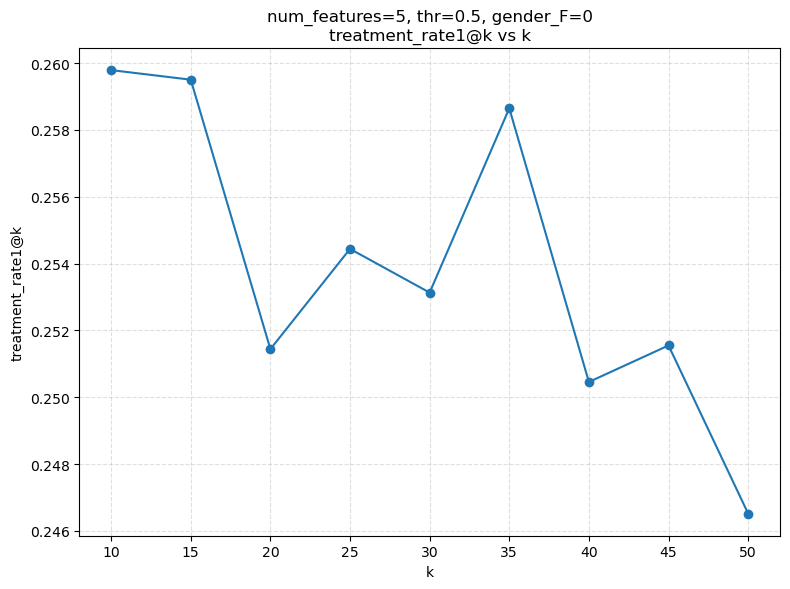

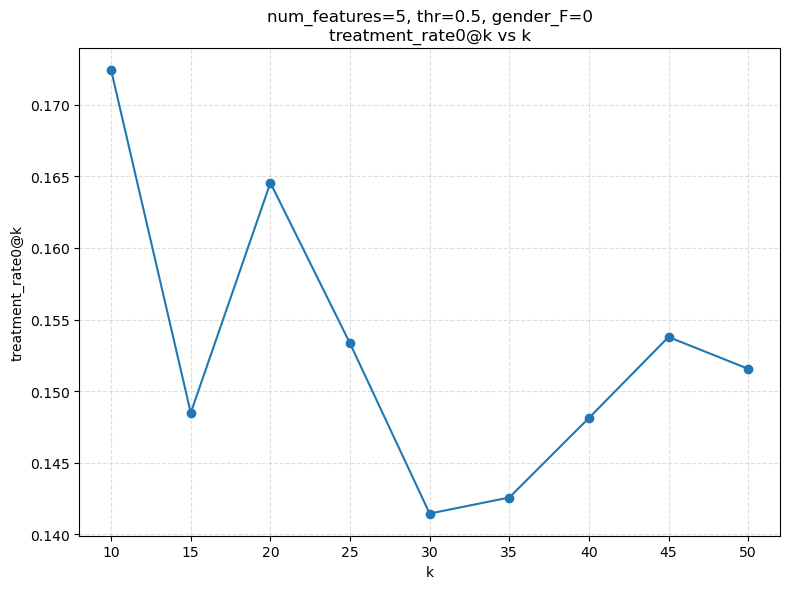

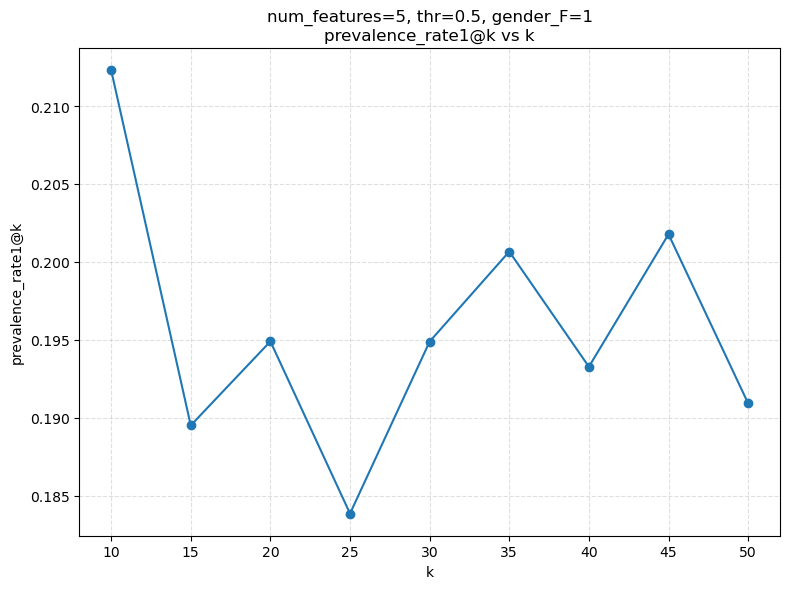

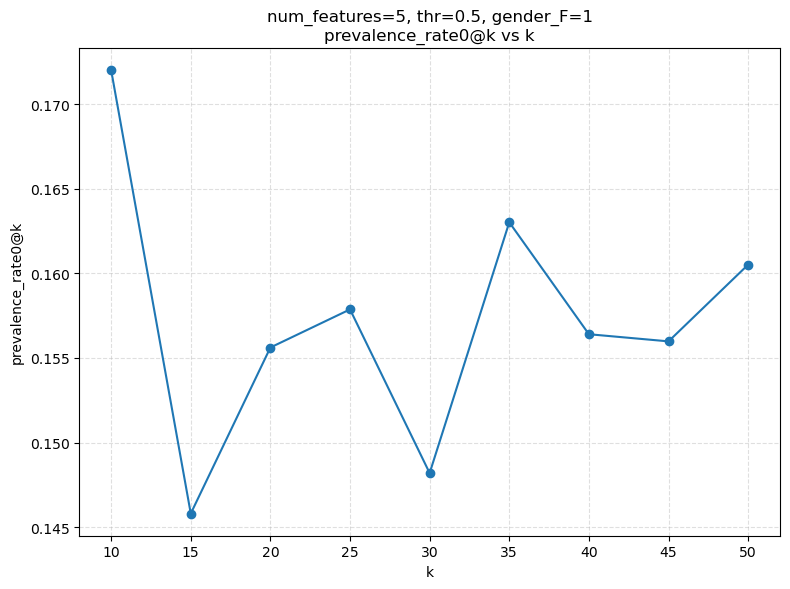

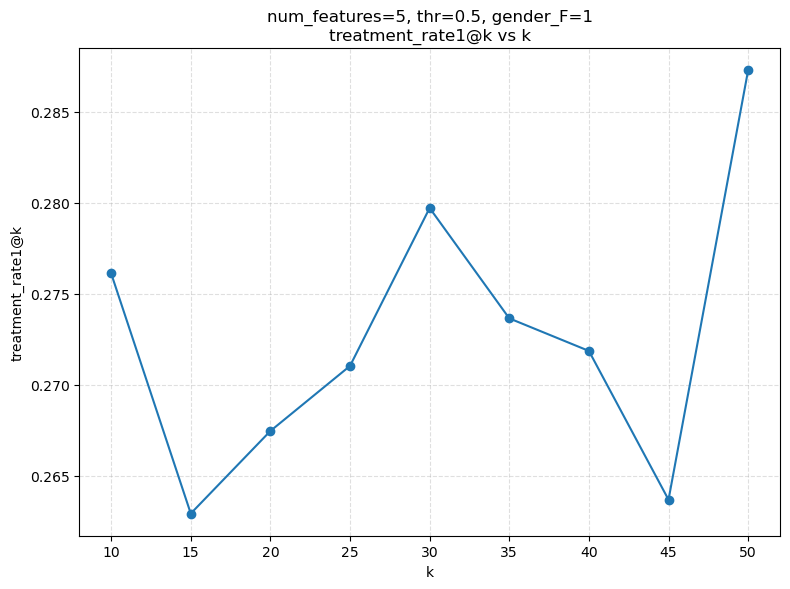

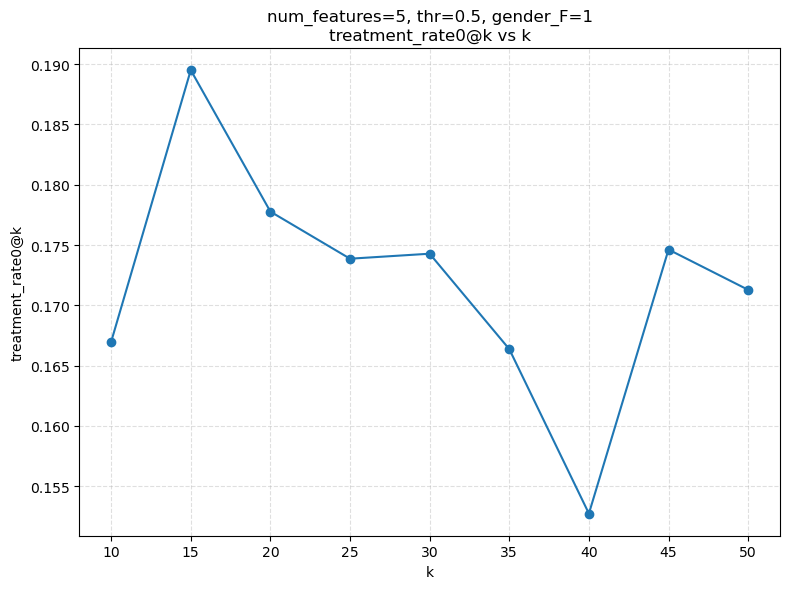

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def line_plot_at_k(
        metric_frame,
        metric_cols=('prevalence_rate1@k', 'prevalence_rate0@k',
                     'treatment_rate1@k',  'treatment_rate0@k')):
    """
    以 k 为横坐标，分别为每个 fairness 切片画多条指标曲线
    """


    # 判断 split 列名
    split_col = ("cumulative_split_point(<= split)"
                 if "cumulative_split_point(<= split)" in metric_frame.columns
                 else "exact_split_point(== split)")

    id_cols = ['num_features', 'threshold', 'fairness_feature', split_col]

    # 先对 k 排序，保证线条顺序正确
    metric_frame = metric_frame.sort_values('k')

    for key, df_sub in metric_frame.groupby(id_cols):
        num_feat, thresh, feat, split_val = key
        title_prefix = (f"num_features={num_feat}, thr={thresh}, "
                        f"{feat}={split_val}")

        for metric in metric_cols:
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.plot(df_sub['k'], df_sub[metric], marker='o')
            ax.set_title(f"{title_prefix}\n{metric} vs k")
            ax.set_xlabel('k')
            ax.set_ylabel(metric)
            ax.set_xticks(df_sub['k'])
            ax.grid(True, linestyle='--', alpha=0.4)
            plt.tight_layout()
            plt.show()
df= pd.read_csv('Fake_fairness-at-k_metrics.csv')
line_plot_at_k(df)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact

def omnibus_proportion_test(df,
                            metric_col,
                            split_col="exact_split_point(== split)",
                            k_col="k",
                            alpha=0.05,
                            simulate_iter=10_000,
                            seed=0):
    """
    Omnibus H0: the metric is the same across all split levels *within*
                each fairness feature.
    Works for any metric that is literally   successes / denominator.

    Returns
    -------
    pandas.DataFrame with columns
        fairness_feature, statistic, dof, p_value, method
    """
    rng   = np.random.default_rng(seed)
    rows  = []

    for feature, sub in df.groupby("fairness_feature"):
        # ---------- build the r × 2 table -------------------------------
        table = []
        for _, row in sub.iterrows():
            if "prevalence_rate1@k" == metric_col:                 
                denom = row['group_1_sizek']
            else:                                 # denominator is group_1_size
                denom = row['group_1_size']

            succ   = row[metric_col] * denom
            fail   = denom - succ
            table.append([succ, fail])

        table = np.asarray(table, dtype=float)     # (r × 2)

        # ---------- decide which test to run ----------------------------
        # 2 levels  → Fisher if a cell < 5, else χ²
        # ≥3 levels → χ²; if any expected <5 → χ² with Monte-Carlo p-value
        method = "chi2"
        dof    = table.shape[0] - 1

        if table.shape[0] == 2:
            # 2×2 case
            exp = chi2_contingency(table, correction=False)[3]
            if (exp < 5).any():
                stat, p = fisher_exact(table, alternative="two-sided")
                method  = "fisher_exact"
                dof     = np.nan
            else:
                stat, p, _, _ = chi2_contingency(table, correction=False)
        else:
            # r×2, r > 2
            stat, p, _, exp = chi2_contingency(table, correction=False)
            if (exp < 5).any():
                # χ² with Monte-Carlo simulated p (no Yates correction)
                stat, p, _, _ = chi2_contingency(
                    table, correction=False, lambda_=None,
                    simulate_pval=True, random_state=rng, MonteCarlo=simulate_iter
                )
                method = f"chi2_sim_{simulate_iter}"

        rows.append({
            "fairness_feature": feature,
            "statistic":        stat,
            "dof":              dof,
            "p_value":          p,
            "method":           method,
        })

    return pd.DataFrame(rows)
